In [1]:
import torch
import os
from PIL import Image
from torchvision import transforms
from torchvision.datasets import DatasetFolder
import cv2
import numpy as np

# We need to write a transform to make it compatible with resnet18 (size 224x224x3, and type tensor)

In [2]:
from torchvision import transforms

transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225])])


def load_image(img_path:str):    
        np_img = cv2.imread(img_path) #CV2 to open and convert BMP mages into NUMPY    
        #np_img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        return Image.fromarray(np_img)  #we need Image for the transforms to work correctly


dset = DatasetFolder(root='RowanDLclassNEA/NEUdata', loader = load_image, extensions = ('.bmp',), transform = transform)

### Note that load_image  needed to return a PIL.Image for the transforms to be correctly applied


In [3]:
from torch.utils.data import random_split

train_set, val_set = random_split(
                      dset, 
                      [1200, 600])

trainloader = torch.utils.data.DataLoader(
                    train_set, 
                    batch_size=16, 
                    shuffle=True)

valloader = torch.utils.data.DataLoader(
                    val_set, 
                    batch_size=16, 
                    shuffle=True)



 ### We are going to illustrate transfer learning now
Transfer starts with a pretrained model from the torchvision library. The pretrained model will be resnet18. This model is trained on ImageNet 1K (this is the default for resnet18: DEFAULT = IMAGENET1K_V1)
The fact that ImageNet consists of RGB images of size 224 x 224 demanded our data resizing in the transform

In [4]:
import torchvision.models as models
import torch.nn as nn
from torchinfo import summary

orig_model = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)

### notice that the last layer of the resnet18 is a linear layer with output size 1000

We will first deepcopy  orig_model (where we instantiated resnet18 with pretrained weights): this will create an INDEPENDENT graph

Then just replace model.fc with the linear layer


In [5]:
import copy
alt_model = copy.deepcopy(orig_model)
alt_model.fc = nn.Linear(512,6)

In [6]:
from torch import optim
from torch import nn
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
Weights_model = alt_model.to(device)

optimizer = optim.SGD(Weights_model.parameters(), 
                      lr=0.001, 
                      momentum=0.9)
 
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=10)



N_EPOCHS = 20
tr_loss_hist_1 = []
val_loss_hist_1 = []
for epoch in range(N_EPOCHS):

    # Training 
    train_loss = 0.0
    Weights_model.train() # <1>
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = Weights_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    Weights_model.eval() # <2>
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = Weights_model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
                  epoch, 
                  train_loss/len(trainloader), 
                  val_loss/len(valloader)))
    tr_loss_hist_1.append(train_loss/len(trainloader))
    val_loss_hist_1.append(val_loss/len(valloader))

Epoch: 0 Train Loss: 0.865738665064176 Val Loss: 0.2687914006804165
Epoch: 1 Train Loss: 0.24827866792678832 Val Loss: 0.10172150940879394
Epoch: 2 Train Loss: 0.16375308692455293 Val Loss: 0.05682138228592904
Epoch: 3 Train Loss: 0.0995722437898318 Val Loss: 0.03960807582265452
Epoch: 4 Train Loss: 0.07519763626158238 Val Loss: 0.026612367431976293
Epoch: 5 Train Loss: 0.05966012589633465 Val Loss: 0.020651678916213934
Epoch: 6 Train Loss: 0.04329455963646372 Val Loss: 0.01691228928240506
Epoch: 7 Train Loss: 0.035131167266517875 Val Loss: 0.014690339442734656
Epoch: 8 Train Loss: 0.0421917572679619 Val Loss: 0.01392252341917667
Epoch: 9 Train Loss: 0.037978319805115464 Val Loss: 0.012896466160830306
Epoch: 10 Train Loss: 0.03255651427122454 Val Loss: 0.011772078995004688
Epoch: 11 Train Loss: 0.027948937534044187 Val Loss: 0.009580203806858902
Epoch: 12 Train Loss: 0.024620541436597705 Val Loss: 0.010054615454895324
Epoch: 13 Train Loss: 0.02792179577673475 Val Loss: 0.00820172882001

Test Accuracy of non weighted Resnet: 0.9375


Text(0.5, 1.0, 'Loss Curves weighted model')

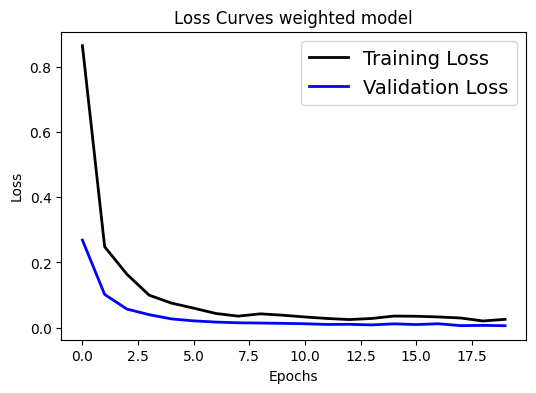

In [7]:


tset = DatasetFolder(root='RowanDLclassNEA/NEUdata_split/Test', loader = load_image, extensions = ('.bmp',), transform = transform)

testloader = torch.utils.data.DataLoader(
                    tset, 
                    batch_size=16, 
                    shuffle=True)

num_correct = 0.0

for x_test_batch, y_test_batch in testloader:

    Weights_model.eval()

    y_test_batch = y_test_batch.to(device)

    x_test_batch = x_test_batch.to(device)

    y_pred_batch = Weights_model(x_test_batch)

    _, predicted = torch.max(y_pred_batch, 1)

    num_correct += (predicted == y_test_batch).float().sum()

accuracy_1 = num_correct/(len(testloader)*testloader.batch_size)

print("Test Accuracy of non weighted Resnet: {}".format(accuracy_1))
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(tr_loss_hist_1, 'black', linewidth=2.0)
plt.plot(val_loss_hist_1, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves weighted model', fontsize=12)

#### This is a different way of changing the resnet18

Let's get rid of the last layer of the resnet18 (output size 1000), because we have only 6 classes!

Plus, add the FlattenLayer to see what is the linearized size of the last AvgPool

We will use this shortened model (vec_model) to build upon it later, but first we will **freeze its parameters** (disable further training)


In [8]:
layers = list(orig_model.children())[:-1]  #get all the layers except the last one
layers.append(nn.Flatten())   
Fixed_model = nn.Sequential(*layers)
for param in Fixed_model.parameters():
    param.requires_grad = False

## Here we will add linear layer to the frozen vec_model

In [9]:
layers = list(Fixed_model.children())  #get all the layers except the last one
layers.append(nn.Linear(512,6))
Fixed_model = nn.Sequential(*layers)

Fixed_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

#### Train vec_model

In [10]:
from torch import optim
from torch import nn
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
Fixed_model = Fixed_model.to(device)

optimizer = optim.SGD(Fixed_model.parameters(), 
                      lr=0.001, 
                      momentum=0.9)
 
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=10)


#from torch.utils.tensorboard import SummaryWriter

N_EPOCHS = 20
tr_loss_hist_2 = []
val_loss_hist_2 = []
for epoch in range(N_EPOCHS):

    # Training 
    train_loss = 0.0
    Fixed_model.train() # <1>
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = Fixed_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    Fixed_model.eval() # <2>
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = Fixed_model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
                  epoch, 
                  train_loss/len(trainloader), 
                  val_loss/len(valloader)))
    tr_loss_hist_2.append(train_loss/len(trainloader))
    val_loss_hist_2.append(val_loss/len(valloader))

Epoch: 0 Train Loss: 1.4489190888404846 Val Loss: 0.8805368605412935
Epoch: 1 Train Loss: 0.7581144499778748 Val Loss: 0.49521155263248245
Epoch: 2 Train Loss: 0.5219244015216827 Val Loss: 0.3528060509186042
Epoch: 3 Train Loss: 0.4249610567092896 Val Loss: 0.2782827015770109
Epoch: 4 Train Loss: 0.34455680588881177 Val Loss: 0.23341582166521171
Epoch: 5 Train Loss: 0.3051404309272766 Val Loss: 0.20371378134740026
Epoch: 6 Train Loss: 0.28812307039896645 Val Loss: 0.17748207069541277
Epoch: 7 Train Loss: 0.2710314213236173 Val Loss: 0.16843055051408315
Epoch: 8 Train Loss: 0.23247634450594584 Val Loss: 0.15287262240522786
Epoch: 9 Train Loss: 0.23082882662614188 Val Loss: 0.15424279025510737
Epoch: 10 Train Loss: 0.21143398890892665 Val Loss: 0.12884260821891458
Epoch: 11 Train Loss: 0.1914911656578382 Val Loss: 0.11955853698677138
Epoch: 12 Train Loss: 0.1888433172305425 Val Loss: 0.12179646827280521
Epoch: 13 Train Loss: 0.17969737167159716 Val Loss: 0.11495621678860564
Epoch: 14 Tra

Test Accuracy of weighted resnet: 0.9166666865348816


Text(0.5, 1.0, 'Loss Curves Fixed model')

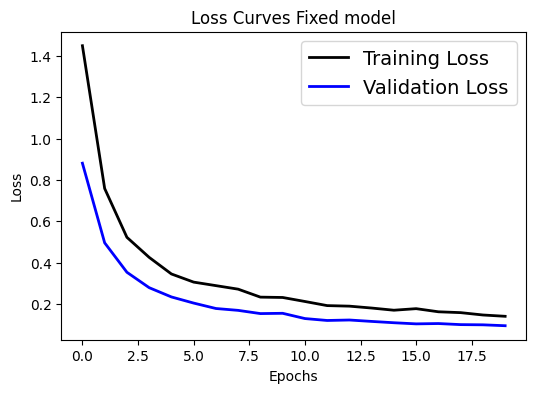

In [12]:

num_correct = 0.0

for x_test_batch, y_test_batch in testloader:

    Fixed_model.eval()

    y_test_batch = y_test_batch.to(device)

    x_test_batch = x_test_batch.to(device)

    y_pred_batch = Fixed_model(x_test_batch)

    _, predicted = torch.max(y_pred_batch, 1)

    num_correct += (predicted == y_test_batch).float().sum()

accuracy_2 = num_correct/(len(testloader)*testloader.batch_size)

print("Test Accuracy of weighted resnet: {}".format(accuracy_2))
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(tr_loss_hist_2, 'black', linewidth=2.0)
plt.plot(val_loss_hist_2, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves Fixed model', fontsize=12)

Differences with respect to neaclass 2 notebook is that the Third model we trained it fixing the weights of the model which reduced the freedom to modify the weights based on the parameter. Hence there is a decrese in the accuracy from 93.75 to 91 percent. 